[[1.]]
[[0.5547364]]


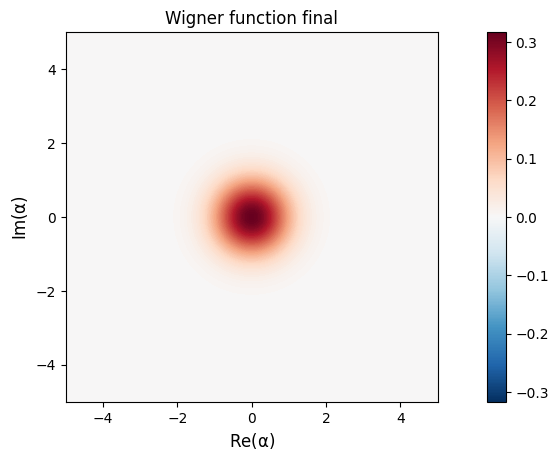

Time     | <X>        | <P>        | <n>        | <Parity>  
-----------------------------------------------------------------
0.0000   | 0.000000   | 0.000000   | 0.000000   | 1.000000
0.0505   | 0.000000   | 0.000000   | 0.033473   | 0.990603
0.1010   | 0.000000   | 0.000000   | 0.101371   | 0.954312
0.1515   | 0.000000   | 0.000000   | 0.178341   | 0.904837
0.2020   | 0.000000   | 0.000000   | 0.254686   | 0.856135
0.2525   | 0.000000   | 0.000000   | 0.326907   | 0.813632
0.3030   | 0.000000   | 0.000000   | 0.393941   | 0.778054
0.3535   | 0.000000   | 0.000000   | 0.455664   | 0.748556
0.4040   | 0.000000   | 0.000000   | 0.512303   | 0.724015
0.4545   | 0.000000   | 0.000000   | 0.564200   | 0.703431
0.5051   | 0.000000   | 0.000000   | 0.611721   | 0.686007
0.5556   | 0.000000   | 0.000000   | 0.655223   | 0.671125
0.6061   | 0.000000   | 0.000000   | 0.695042   | 0.658314
0.6566   | 0.000000   | 0.000000   | 0.731487   | 0.647207
0.7071   | 0.000000   | 0.000000   | 0.764843  

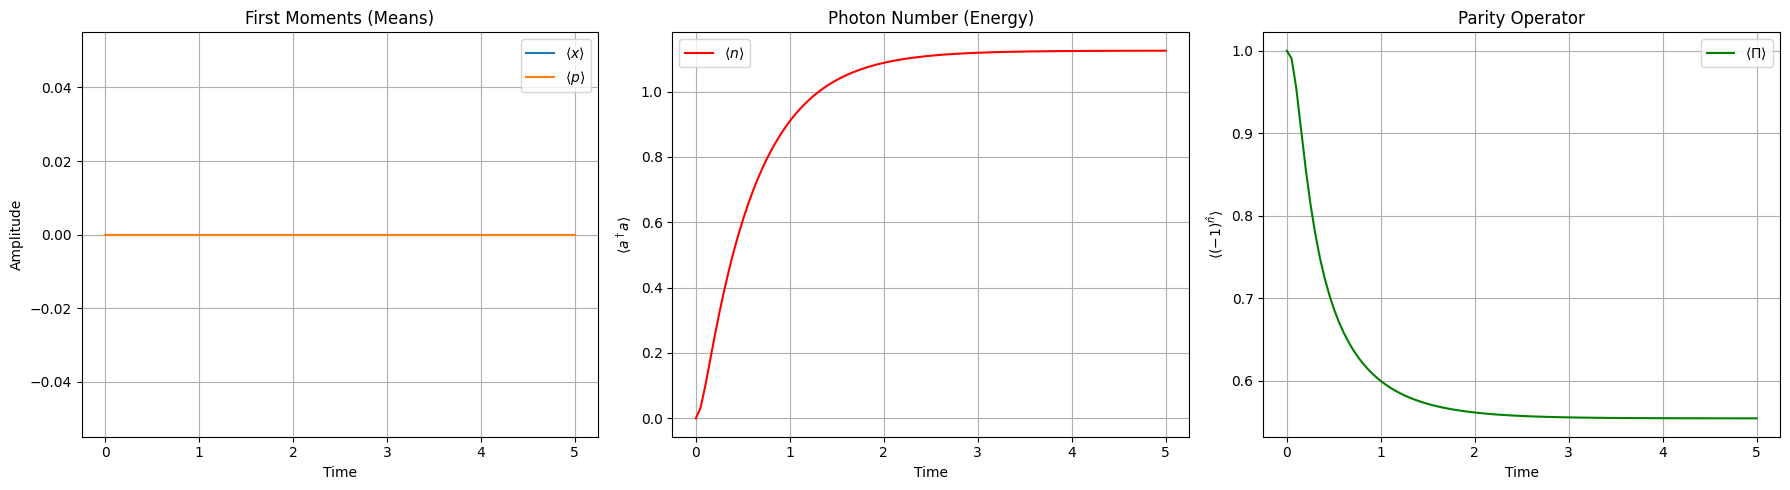

In [19]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# Identical to your JAX setup
G = 3 + 3j    # Two-photon drive strength
delta = 1       # Detuning
U = 0           # Kerr nonlinearity
gamma = 10      # Single-photon loss rate

# Simulation parameters
N = 100            # Hilbert space cutoff (must be high enough to capture squeezing)
t_start = 0.0
t_end = 5
steps = 100       # Higher resolution than the Euler step
tlist = np.linspace(t_start, t_end, steps)

# --- 2. Operators ---
a = qt.destroy(N)
n_op = a.dag() * a
x_op = (a + a.dag()) / np.sqrt(2) # Position quadrature
p_op = 1j * (a.dag() - a) / np.sqrt(2) # Momentum quadrature

# Parity operator defined as exp(i * pi * n)
# Equivalently, it is a diagonal matrix with entries (-1)^n
parity_op = (1j * np.pi * n_op).expm() 

# --- 3. Hamiltonian Construction ---
# H_detuning = delta * a^dag * a
H_det = -delta * n_op

# H_kerr = (U/2) * a^dag^2 * a^2 (Standard Kerr form)
H_kerr = 0.5 * U * a.dag()**2 * a**2

# H_drive = G * a^dag^2 + G* * a^2 (Two-photon drive)
# Note: In some conventions, this might be i(G a^dag^2 - G* a^2).
# Based on your JAX summation, it implies a direct Hermitian addition:
H_drive = (G/2 * a.dag()**2) + (np.conj(G)/2 * a**2)

# Total Hamiltonian
# To simulate the "Only G term" case, set delta=0 and U=0 here.
H = H_drive + H_det + H_kerr

# --- 4. Dissipation ---
# Single photon loss: sqrt(gamma) * a
c_ops = [np.sqrt(gamma) * a]

# --- 5. Initial State ---
# Vacuum state
psi0 = (qt.coherent(N, 2) + qt.coherent(N, -2)).unit()
psi0 = qt.basis(N, 0)

print(np.pi*qt.wigner(psi0, 0, 0))

# --- 6. Solve Master Equation ---
result = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[x_op, p_op, n_op, parity_op], options={"store_states":True})

# --- 7. Plotting & Verification ---
means_x = result.expect[0]
means_p = result.expect[1]
means_n = result.expect[2]
means_parity = result.expect[3]

fig, ax = qt.plot_wigner(result.states[0], xvec=np.linspace(-5,5,100), yvec=np.linspace(-5,5,100), colorbar=True, cmap='RdBu_r')


print(np.pi*qt.wigner(result.states[-1], 0, 0))

# Add plot customizations (optional)
ax.set_title("Wigner function final")
plt.show()

print(f"{'Time':<8} | {'<X>':<10} | {'<P>':<10} | {'<n>':<10} | {'<Parity>':<10}")
print("-" * 65)
for i in range(0, len(tlist), 1): # Print every 10th step
    print(f"{tlist[i]:.4f}   | {means_x[i]:.6f}   | {means_p[i]:.6f}   | {means_n[i]:.6f}   | {means_parity[i]:.6f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Means
ax[0].plot(tlist, means_x, label=r'$\langle x \rangle$')
ax[0].plot(tlist, means_p, label=r'$\langle p \rangle$')
ax[0].set_title("First Moments (Means)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[0].grid(True)

# Plot Photon Number
ax[1].plot(tlist, means_n, label=r'$\langle n \rangle$', color='r')
ax[1].set_title("Photon Number (Energy)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$\langle a^\dagger a \rangle$")
ax[1].legend()
ax[1].grid(True)

# Plot Parity
ax[2].plot(tlist, means_parity, label=r'$\langle \Pi \rangle$', color='g')
ax[2].set_title("Parity Operator")
ax[2].set_xlabel("Time")
ax[2].set_ylabel(r"$\langle (-1)^{\hat{n}} \rangle$")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()